run `ipcluster start` prior to running the notebook if you want parallel functionality.

alternatively, run `ipcluster nbextension enable` to enable the notebook extension

requires `ipyparallel` package (`pip install ipyparallel`)

In [1]:
import ipyparallel as ipp

In [2]:
# import the package functions
from ThinLayer import fkmod as tl
from ThinLayer import rockphysics as rp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

Loading ThinLayer package


In [3]:
c = ipp.Client()
v=c[:]
path = %pwd
v['path'] = path

# parallel dependencies
with v.sync_imports():
    import numpy
    from numpy.linalg import inv
    from scipy import special
    import time, sys
    %px sys.path.append(path)
    from ThinLayer import fkmod
    from ThinLayer import rockphysics
    
%px np = numpy
%px scs = special
%px tl = fkmod
%px rp = rockphysics

importing numpy on engine(s)
importing inv from numpy.linalg on engine(s)
importing special from scipy on engine(s)
importing time on engine(s)
importing sys on engine(s)
importing InteractiveShell from IPython.core.interactiveshell on engine(s)
importing fkmod from ThinLayer on engine(s)
importing rockphysics from ThinLayer on engine(s)


# Numerical example

### define the model

Define dictionary `model` to store the model/modeling parameters: layers, thickness, source and receiver depths, source frequency, frequency and offset vector, number of integration points etc.

dictionary `layers` is a pool of frequency-independent media to select from

dictionary `layersF` is a pool of frequency-dependent media to select from

the elastic constants correspond to an VTI medium and are to be given in order ($c_{11}, c_{13}, c_{33}, c_{44}, \rho$).

dictionary `model_layers` is a sequence of layers used in modeling

dictionary `model_thickness` is a sequence of layers thickness

In [9]:
def create_model(Nrep, D= 0.5, l= 100):
    ## frequency-independent layers
    layers = {
    "layer 1":[22.56, 12.38, 17.35, 3.15, 2.38],
    "layer 2":[26.73, 12.51, 26.73, 7.11, 2.22]
    };

    ## frequency-dependent layers
    #  l defines the fracture length ratio
    den = 2.15 # density
    layersF = {
    'layer P': lambda w: np.append(rp.AnisSquirtModel(10.6957,21.9734,0.28,2.4,0.02,0,1e-5,2e-5,w,0)[:-1],den),
    'layer F': lambda w: np.append(rp.AnisSquirtModel(10.6957,21.9734,0.28,2.4,0.02,0.03,1e-5,2e-5,w,l)[:-1],den)
    }
    
    ## crete a thin-bedded sequence repeated Nrep times
    #  with a total thickness of 0.5
    top = ['layer P', 'layer F']
    seq = ['layer P', 'layer F'] * Nrep
    bot = ['layer P']
    model_layers = top + seq + bot
    thickness = 0.1* np.random.random(2*Nrep+1) + 0.1
    thickness = thickness/np.sum(thickness) * D
    thickness = np.r_[0,thickness,0]
    
    # ouput model dictionary
    model={
    "layers": layers,                               # pool of frequency-independent layers (constants)
    "layersF": layersF,                             # pool of frequency-dependent layers (functions)
    "model_layers": model_layers,                   # sequence of layers
    "model_thickness":  thickness,                  # sequence of thicknesses
    "zSource":.4,                                   # source depth
    "zReceiver":.8,                                 # depth of the first boundary
    "srcw": 15,                                     # source frequency
    "omega": 2*np.pi*np.arange(0.5,50.5,0.5),       # frequency vector
    "r": np.arange(0.05,2.05,0.05),                 # offset vector
    "nslow": 1500                                   # number of integration points
    }
    
    return model

In [10]:
# create the model with 1 repetition
model = create_model(1)
print(model['model_layers'],model['model_thickness'])

['layer P', 'layer F', 'layer P', 'layer F', 'layer P'] [0.         0.20472067 0.13449422 0.1607851  0.        ]


## Sample gather

In [11]:
Uz, elapsed = tl.FKmodeling_par(v, model)
print(str(elapsed)+' sec')

frequency dependence
228.23308777809143 sec


In [12]:
taxis = tl.ftot(Uz[0],model['omega'],model['srcw'])[0]
gather = np.array([tl.ftot(Uz[i],model['omega'],model['srcw'])[1] for i in range(len(Uz))])

(1, 0)

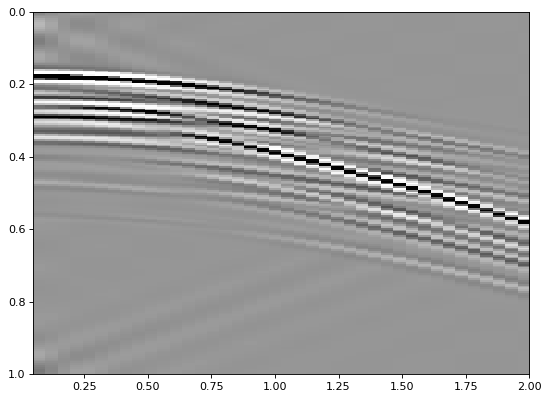

In [13]:
drange = [np.amin(model['r']), np.amax(model['r']), np.amax(taxis), np.amin(taxis)];
vm = np.percentile(gather, 99)

plt.figure(figsize=(8, 6), dpi= 80)
plt.imshow(gather.T, cmap="Greys", vmin=-vm, vmax=vm, aspect='auto', extent=drange)
plt.ylim([1,0])